<a href="https://colab.research.google.com/github/sayakpaul/robustness-vit/blob/main/analysis/attention_maps/Visualizing_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Majority of the code is taken from the following repositories:
* https://github.com/jeonsworld/ViT-pytorch
* https://github.com/jacobgil/vit-explain

## Setup

In [6]:
!gdown --id 1Ad0dOIRxuPffiOY5As6Kod1Hhi5OG4Do

Downloading...
From: https://drive.google.com/uc?id=1Ad0dOIRxuPffiOY5As6Kod1Hhi5OG4Do
To: /content/paths_vit.pkl
100% 16.1k/16.1k [00:00<00:00, 26.7MB/s]


In [1]:
!wget -q https://people.eecs.berkeley.edu/~hendrycks/imagenet-a.tar
!tar xf imagenet-a.tar

In [2]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json

--2021-05-04 13:16:11--  https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      

2021-05-04 13:16:12 (132 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [3]:
!pip install -q timm

     |████████████████████████████████| 296kB 9.6MB/s 


In [1]:
import typing
import io
import os
import pickle
import json

import timm
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms

## Utilities

In [2]:
with open("imagenet_class_index.json", "r") as read_file:
    imagenet_labels = json.load(read_file)
    
MAPPING_DICT = {}
LABEL_NAMES = {}
for label_id in list(imagenet_labels.keys()):
    MAPPING_DICT[imagenet_labels[label_id][0]] = int(label_id)
    LABEL_NAMES[int(label_id)] = imagenet_labels[label_id][1]

IMAGENET_A_PATHS = pickle.loads(open("paths_vit.pkl", "rb").read())

In [3]:
# Prepare Model
vit_model = timm.create_model('vit_large_patch16_384', pretrained=True).to("cuda")
vit_model.eval()

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and Test

In [4]:
high_conf_paths = []
high_confs = []
high_preds = []
low_conf_paths = []
low_confs = []
low_preds = []

with torch.no_grad():
    for image_path in IMAGENET_A_PATHS:
        label = image_path.split("/")[1]
        label_idx = MAPPING_DICT[label]
        
        im = Image.open(image_path)
        x = transform(im).to(DEVICE)
        
        logits = vit_model(x.unsqueeze(0))
        confidence = torch.nn.Softmax(dim=1)(logits.detach().cpu())
        prediction = confidence.argmax(dim=1)

        if prediction.eq(label_idx) and (confidence.max() > 0.8):
            high_conf_paths.append(image_path)
            high_confs.append(confidence.max().numpy().tolist())
            high_preds.append(LABEL_NAMES[label_idx])
        elif prediction.eq(label_idx) and (confidence.max() < 0.8):
            low_conf_paths.append(image_path)
            low_confs.append(confidence.max().numpy().tolist())
            low_preds.append(LABEL_NAMES[label_idx])

In [5]:
len(high_conf_paths), len(low_conf_paths)

(4, 5)

## Attention Rollout 

In [6]:
# Taken from:
# https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py

def rollout(attentions, discard_ratio, head_fusion):
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 1 :]
    # In case of 224x224 image, this brings us from 196 to 14
    width = int(mask.size(-1)**0.5)
    mask = mask.reshape(width, width).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)

        return rollout(self.attentions, self.discard_ratio, self.head_fusion)

In [9]:
# https://github.com/jacobgil/vit-explain/blob/main/vit_explain.py
def show_mask_on_image(img, mask):
    mask = cv2.resize(mask, (img.shape[0], img.shape[1]))
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

In [32]:
def visualize(images, results, preds, probs, name="attn_map_nae_high.png"):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8, 4))
    for i in range(2):
        for j in range(4):
            # if i == 1:
            #     ax[i, j].set_title(f"Prediction: {preds[i]} \n"
            #                         'Confidence: {:.2f}'.format(probs[i]), 
            #                        fontsize=12)
            ax[i, j].axis("off")
            
            if i == 0:
                _ = ax[i, j].imshow(images[j])
            elif i == 1:
                _ = ax[i, j].imshow(results[j])
    
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.savefig(f"{name}", dpi=300, bbox_inches="tight")

In [11]:
roller = VITAttentionRollout(vit_model, discard_ratio=0.9)
images, results, preds, probs = [], [], [], []

for i, image_path in enumerate(high_conf_paths):
    im = Image.open(image_path)
    x = transform(im).to(DEVICE)
    mask = roller(x.unsqueeze(0))
    output = show_mask_on_image(np.array(im.resize((224, 224))), mask)

    images.append(np.array(im.resize((224, 224))))
    results.append(output)
    preds.append(high_preds[i])
    probs.append(high_confs[i])
    

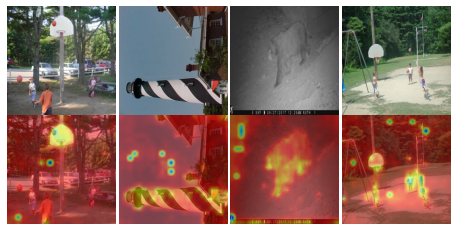

In [33]:
visualize(images, results, preds, probs, name="attn_map_nae_high.png")

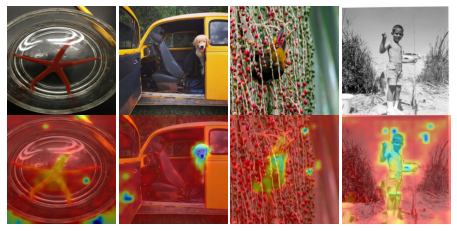

In [34]:
images, results, preds, probs = [], [], [], []

for i, image_path in enumerate(low_conf_paths[:4]):
    im = Image.open(image_path)
    x = transform(im).to(DEVICE)
    mask = roller(x.unsqueeze(0))
    output = show_mask_on_image(np.array(im.resize((224, 224))), mask)

    images.append(np.array(im.resize((224, 224))))
    results.append(output)
    preds.append(low_preds[i])
    probs.append(low_confs[i])
    
visualize(images, results, preds, probs, name="attn_map_nae_low.png")